> This post was generated from a Jupyter notebook; it can be found [here](https://github.com/tom-beer/Synthetic-Control-Examples) 

Suppose we want to estimate the causal effect of:
* An anti smoking taxation program in California on cigarette consumption

or
* The German reunification on West Germany’s economy

or
* Right to carry laws on violent crimes in Texas

or
* Uber and Lyft on traffic congestion in Paris

What would be a sensible approach to answer these questions? For practitioners coming from domains like healthcare, advertisement or collaborative filtering, these questions do not seem to fit in their everyday way of thinking. The reason is that for these questions, we are interested in the effect of an intervention for a single unit, while we do not have any data about this intervention for other units. 

Take the German reunification as an example - it is only Germany that was reunified, and the task is to infer the causal effect of that historic event. As for the other examples - sure, California was not the first to implement an anti-smoking program, and Uber is active in many cities over the globe apart from Paris. But the task considered here is to use only the intervention data for the unit in question.

***
## The qualitative approach

It seems insensible to make inferences on a single unit - what credibility could we attain? What would be the statistical properties of the estimator? But for decades, qualitative analyses that seem unsensible were carried out by economists and social scientists. They would meticulously find relevant controls for the relevant treated unit, relying on informal statements of affinity between the units. Then, with a chosen control unit, identification schemes like difference-in-differences would be applied. This approach has some merit - the resulting estimator is interpretable, transparent and simple. It is easy to communicate it and argue about the choice of control units. Yet it's clear that it is not the optimal approach, at least for practitioners of the quantitative/statistical learning school. So the question is - can we do better? Can we devise a data-driven approach for causal effect estimation of aggregate interventions? Can we phrase a clear objective for the estimator?
***
## Synthetic Controls
Introduced in 2003 and formalized in 2010 by Alberto Abadie and colleagues, the synthetic control aims to bridge between the traditional qualitative approaches of the social sciences and the modern data driven approaches. It strikes a balance between the two by offering a clear objective function to optimize while constraining the model to remain transparebt, interpretable and simple. It is applicable to almost any domain, and became very popular thanks to its lenient assumptions. Esteemed economists Susan Athey and Guido Imbens have called it "arguably the most important innovation in the policy evaluation literature in the last 15 years". Sounds interesting? Let's dive in.


***
### The main idea
The qualitative approach calls for a manual selection of control units from a pool of potential control units. The main idea of the synthetic control method is to forgo any kind of manual control selection. Instead, the method makes use of **all** the control units in a data-driven approach. The controls are weighted based on their similarity to the treated unit, yielding the synthetic control as a weighed combination of the original units.

<details>
  <summary><b>Potential outcomes</b></summary>
  We can formalize the main idea above in the language of potential outcomes:

  - For the control units, we observe the potential outcome under no-intervention
  - For the treated unit, we observe its potential outcome under no-intervention in the pre-intervention period, and its potential outcome under the intervention in the post-intervention period
  - To calculate the causal effect, we need the treated unit's potential outcome under no-intervention in the post-intervention period
  - The synthetic control emulates this potential outcome. It attempts to answer the question of "What would have been the outcome for the treated unit, without the intervention?"
</details>

We see that the task of causal effect estimation boils down to finding the optimal weighting of the control units.
And how shall one find the optimal weights? This is the point where the road forks - there are many suggestions for phrasing of the optimization problem, each with its own pros and cons. The next section will describe one possibility, which is the originally proposed apparoch by Abadie et al; A discussion of its limitations in face of more contemporary approaches will follow. But first - some (minimal) notation.

***

### The setting
- We have data for $T$ time periods, $T_0$ of them are pre-intervention and $T_1$ belong to the post-intervention period
- We have $J$ control units, $j\in\{1,..,n\}$, and one treated unit ($j=0$)
- The measured outcomes for each unit and time period is $Y_{jt} \in \mathbb{R}^{T \times J+1}$
- The synthetic control is defined as $\sum_{j=1}^{J} Y_{jt} \cdot W_j$
- The causal effect estimate is thus $\tau_t = Y_{0t} - \sum_{j=1}^{J} Y_{jt} \cdot W_j$
- In addition, for some methods we require a set of $K$ outcome predictors for each unit: $X_{kj}\in \mathbb{R}^{K \times J+1}$. These may be lagged outcomes (pre-intervention) or other auxiliary features (or both)

***

### ADH's synthetic control
Proposed by Abadie, Diamond and Hainmueller (hence the name) in [this paper](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746), this is the seminal proposal for policy evaluation using synthetic controls. Apart from introducing the main idea above, they present the following objective function:

$$W^* \in argmin_{W \in {\Delta}^{J}} \lVert \mathbf{X_0-X_{\neg0} \cdot W} \rVert  $$

Some remarks:
- The similarity between the controls and the treated units is measured with respect to the features $X$, while the synthetic control is constructed using the outcomes $Y$. It might seem more sensible to perform the matching with respect the outcome from the start. After all, we are interested in a good pre-treatment fit for the outcome, and the best fit would be obtained using the outcome and not a proxy for it. Indeed, recent works claim that "*covariates are of less relevance in applications; outcomes tend to be substantially more important than covariates in terms of predictive power*" ([see here](https://arxiv.org/abs/1607.00699))


- The weights are constrained to lie in the J-simplex, i.e. they should be non-negative and sum to one. The authors impose this constraint to avoid extrapolation and increase the method's transparency. But like the previous point, here too recent studies recommend to remove this constraint, stating that it is not obvious that restricting the weights this way is optimal ([see here](https://arxiv.org/abs/1607.00699)). From a different angle, this constraint could be seen as weight regularization, for example [this work](https://arxiv.org/pdf/1803.00096.pdf) shows an equivalence between the simplex constraint and LASSO regularization with a fixed coefficient. The question that arises is - why use a fixed-strength regularization, instead of using LASSO with cross-validation?

These are valid and thoughtful concerns. I think it would be best to take the main idea of the synthetic control method, but to experiment with the implementation details for each use case.

***

## An example use case
### Estimating the effect of California’s tobacco control program
This section will demonstrate the described method on a specific use case. The case of California's tobacco control program was one of the first applications of the synthetic control method, and it was introduced in [this paper](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746). I will recover all steps: data processing, feature extraction, synthetic control construction and causal effect estimation - exactly as shown in the paper and described above (no modifications at all to the original method). If something wasn't clear above - hopefully this example will clarify things up.

##### The research question
In 1988 California implemented a large scale tobacco control program, called proposition 99, that increased  California’s cigarette excise tax by 25 cents per pack, earmarked the tax revenues to health and anti-smoking education budgets, funded anti-smoking media campaigns, and spurred local clean indoor-air ordinances throughout the state. The question we are interested here it to evaluate the policy's effect in terms of per-capita cigarette consumption. The potential control in this case are all US states (that's an [RAS](https://en.wikipedia.org/wiki/RAS_syndrome)).

In [1]:
#hide
from matplotlib import pyplot as plt
import pyreadr
import numpy as np
import pandas as pd
import copy
from scipy.optimize import fmin_slsqp
from sklearn.metrics import mean_squared_error

START_TIME = 1970
INTERVENTION_TIME = 1989
STOP_TIME = 2001

##### Data
- The main outcome is annual per-capita cigarette consumption. The data for this can be found [here](https://github.com/johnson-shuffle/mixtape/tree/master/data).
- In addition to the main outcome, we will utilize some features that correlate with it (GDP, ages, beer consumption etc). This data is taken from [here](https://github.com/jehangiramjad/tslib/tree/master/tests/testdata).

In [2]:
df_outcome_raw = pd.read_csv('../Data/prop99.csv')
df_outcome_raw = df_outcome_raw[df_outcome_raw['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
df_outcome = pd.DataFrame(df_outcome_raw.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year']).to_records())

rda_predictors = pyreadr.read_r('../Data/smoking.rda')
df_predictors = pd.DataFrame(list(rda_predictors.values())[0])
print(f'In the original dataset there are {df_outcome.LocationDesc.unique().shape[0]} states')

In the original dataset there are 51 states


As part of the method's assumptions and requirements, it is important to exclude from the donor pool (this is how the collection of control units is traditionally called) any unit that may not be a true control - i.e. any unit that has implemented a similar intervention. In our case, some states also introduced anti-smoking programs or substantially increased the tax for cigarettes:

In [3]:
bad_states = ['Massachusetts', 'Arizona', 'Oregon', 'Florida', 'Alaska', 'Hawaii', 'Maryland', 
              'Michigan', 'New Jersey', 'New York', 'Washington', 'District of Columbia']

df_outcome.drop(df_outcome[df_outcome['LocationDesc'].isin(bad_states)].index, inplace=True)
ca_id = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item()
df_outcome = df_outcome.reset_index()
df_outcome = df_outcome.rename(columns={'index': 'org_index'})
print(f'After filtering out some states, we are left with {df_outcome.LocationDesc.unique().shape[0]} states (including California):')
df_outcome.head()

After filtering out some states, we are left with 39 states (including California):


,org_index,LocationDesc,1970,1971,1972,1973,1974,1975,1976,1977,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Alabama,89.8,95.4,101.1,102.9,108.2,111.7,116.2,117.1,...,82.4,83.3,80.2,78.0,75.6,71.5,68.4,67.2,64.6,61.7
1,3,Arkansas,100.3,104.1,103.9,108.0,109.7,114.8,119.1,122.6,...,82.1,81.4,78.4,77.0,72.6,63.2,61.1,60.5,57.5,54.4
2,4,California,123.0,121.0,123.5,124.4,126.7,127.1,128.0,126.4,...,33.1,32.9,31.8,30.3,28.8,26.3,26.0,25.2,23.9,22.7
3,5,Colorado,124.8,125.5,134.3,137.9,132.8,131.0,134.2,132.0,...,57.9,53.1,51.1,48.4,46.0,41.4,40.6,40.6,38.3,36.7
4,6,Connecticut,120.0,117.6,110.8,109.3,112.4,110.2,113.4,117.3,...,49.9,50.9,50.5,47.4,45.9,40.8,36.3,33.5,31.4,30.1


Let's construct the matrices defined above:

In [4]:
df_outcome_ca = df_outcome.loc[df_outcome['LocationDesc'] == 'California', :]
df_outcome_control = df_outcome.loc[df_outcome['LocationDesc'] != 'California', :]

ca_outcomes_pre = df_outcome_ca.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.reshape(-1,1)
control_outcomes_pre = df_outcome_control.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.transpose()

ca_outcomes_post = df_outcome_ca.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.reshape(-1,1)
control_outcomes_post = df_outcome_control.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.transpose()

In [5]:
# hide
Z0 = control_outcomes_pre
Z1 = ca_outcomes_pre
Y0 = control_outcomes_post
Y1 = ca_outcomes_post

If we plot the outcomes for California vs. an average of all US states, we see that the 'average control state' is not like California in the pre-intervention period, violating the parallel trends assumption required to draw inferences. Therefore we will find an optimal weighting that would attain a good fit to California in the pre-intervention period. 

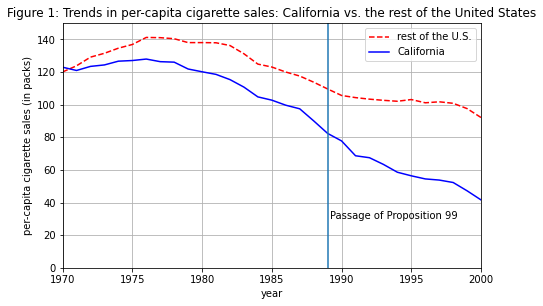

In [6]:
mean_outcomes = np.vstack([control_outcomes_pre, control_outcomes_post]).mean(axis=1)
CA_outcomes = np.vstack([ca_outcomes_pre, ca_outcomes_post]).flatten()
fig = plt.figure(figsize=(7.5,4.5))
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the U.S.");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: Trends in per-capita cigarette sales: California vs. the rest of the United States")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 150])
plt.grid()
plt.show()

In [7]:
# hide
def extract_predictor_vec(state):
    df_outcome_state = df_outcome[df_outcome['LocationDesc'] == state]
    cigsale88_predictor = df_outcome_state['1988'].item()
    cigsale80_predictor = df_outcome_state['1980'].item()
    cigsale75_predictor = df_outcome_state['1975'].item()
    
    state_id_predictors_df = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item() + 1
    df_predictors_state = df_predictors[df_predictors['state'] == state_id_predictors_df]
    beer_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1984) & (df_predictors_state['year'] < INTERVENTION_TIME), 'beer'].mean()
    age15to24_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'age15to24'].mean()*100  # Should I turn multiply by 100? In table 1 it looks like it
    retprice_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'retprice'].mean()
    lnincome_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'lnincome'].mean()
    
    return np.array([lnincome_predictor, age15to24_predictor, retprice_predictor, beer_predictor,  
                     cigsale88_predictor, cigsale80_predictor, cigsale75_predictor]).reshape(-1,1)

Now let's extract the covariates used in the paper. 
> Note that some of the boilerplate code has been rendered out of the html file, but it can be found in the original notebook [here]()

In [8]:
control_predictors = []
for state in df_outcome['LocationDesc'].unique():
    state_predictor_vec = extract_predictor_vec(state)
    if state == 'California':
        ca_predictors = state_predictor_vec
    else:
        control_predictors += [state_predictor_vec]

control_predictors = np.hstack(control_predictors)

In [9]:
#hide
X0 = control_predictors
X1 = ca_predictors

And here is how we optimize the objective function. 

Note that in the original paper, the authors suggested to add feature importance weights $V$ to be tuned simultaneously with the control weights $W$. I am not convinced that these are required, especially if all features are scaled properly. But in order to reproduce the same results as in the paper, these importance weights are tuned here too. Without them, the optimization would have been a single line of least squares..

In [10]:
def w_mse(w, v, x0, x1): return mean_squared_error(x1, x0.dot(w), sample_weight=v)

def w_constraint(w, v, x0, x1): return np.sum(w) - 1

def v_constraint(V, W, X0, X1, Z0, Z1): return np.sum(V) - 1

def fun_w(w, v, x0, x1): return fmin_slsqp(w_mse, w, bounds=[(0.0, 1.0)]*len(w), f_eqcons=w_constraint, 
                                           args=(v, x0, x1), disp=False, full_output=True)[0]

def fun_v(v, w, x0, x1, z0, z1): return mean_squared_error(z1, z0.dot(fun_w(w, v, x0, x1)))

def solve_synthetic_control(X0, X1, Z0, Z1, Y0):
    k,j = X0.shape
    V0 = 1/k*np.ones(k)
    W0 = 1/j*np.zeros(j).transpose()
    V = fmin_slsqp(fun_v, V0, args=(W0, X0, X1, Z0, Z1), bounds=[(0.0, 1.0)]*len(V0), disp=True, f_eqcons=v_constraint, acc=1e-6)
    W = fun_w(W0, V, X0, X1)
    return V, W

V, W = solve_synthetic_control(control_predictors, ca_predictors, control_outcomes_pre, ca_outcomes_pre, control_outcomes_post)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 23.45850495358178
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1


The optimization terminated successfully, but we need to examine obtained fit with respect to the features. The values for the 'average state' are shown for reference.

In [11]:
mean_predictors = X0.mean(axis=1)
print("Table 1: Cigarette sales predictor means \n")
display(pd.DataFrame(np.hstack([X1, X0.dot(W).reshape(-1,1), mean_predictors.reshape(-1,1)]), 
             columns=['Real California', 'Synthetic California', 'Average of 38 Controls']))

Table 1: Cigarette sales predictor means 



,Real California,Synthetic California,Average of 38 Controls
0,10.076559,10.076559,10.076559
1,17.353238,17.353238,17.353238
2,89.422223,89.422223,89.422223
3,24.280000,24.280000,24.280000
4,90.100000,90.099950,113.823684
5,120.200000,120.200020,138.089474
6,127.100000,127.100214,136.931579


Seems perfect. 

We can inspect which of the states contributed most to the synthetic control construction. These states are interpreted to be similar to California. And because of the simplex constraint, the solution is sparse - there are just a few states with non-negative weights.

In [12]:
largest_weights = list(df_outcome['LocationDesc'].values[1+np.flip(W.argsort())][:5])
print(', '.join(largest_weights))

Utah, North Carolina, North Dakota, Montana, New Hampshire


Now Let's construct and examine the obtained synthetic control:

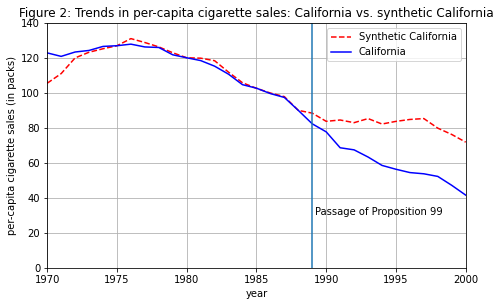

In [13]:
SC_outcomes = np.vstack([Z0, Y0]).dot(W)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),SC_outcomes, 'r--', label="Synthetic California");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 2: Trends in per-capita cigarette sales: California vs. synthetic California")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 140])
plt.grid()
plt.show()

The pre-intervention fit is reasonable, so we can move on with confidence to calculate the causal effect. This is as simple as subtracting the two lines:

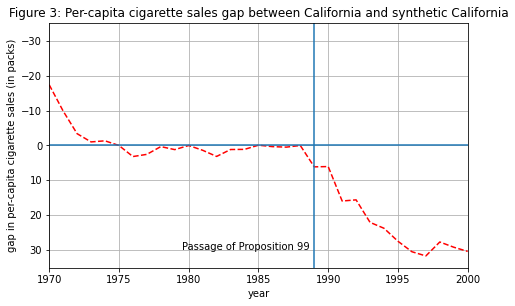

In [14]:
Gap_outcome = np.vstack([Z0, Y0]).dot(W) - np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),Gap_outcome, 'r--');
plt.ylabel('gap in per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.title("Figure 3: Per-capita cigarette sales gap between California and synthetic California")
plt.axhline(0)
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-9.5, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([35, -35])
plt.grid()
plt.show()

With this plot, we can carefully conclude that the implementation of proposition 99 has caused a per-capita reduction of around 26 packs of cigarettes each year. Not bad!

This post introduced the synthetic control method for policy evaluation and demonstrated its use on a famous example. I think this is a very interesting and fun topic that does not receive the attention it deserves. It is widely applicable and requires minimal and reasonable assumptions. The next post will go through another example that has not been addressed yet - what is the effect of Haifa's newly introduced low emission zone (LEZ)? Stay tuned!